# Exercises: CH10 Introduction to Artificial Neural Networks with Keras


10. Train a deep MLP on the MNIST dataset (you can load it using tf.keras.
    datasets.mnist.load_data()). See if you can get over 98% accuracy by man‐
    ually tuning the hyperparameters. Try searching for the optimal learning rate by
    using the approach presented in this chapter (i.e., by growing the learning rate
    exponentially, plotting the loss, and finding the point where the loss shoots up).
    Next, try tuning the hyperparameters using Keras Tuner with all the bells and
    whistles—save checkpoints, use early stopping, and plot learning curves using
    TensorBoard.


In [182]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Normalization, Input

from tensorflow.keras.datasets.mnist import load_data
import matplotlib.pylab as plt
from pathlib import Path

In [3]:
mnist = load_data()

In [135]:
(X_trainf, y_trainf), (X_test, y_test) = load_data()

X_train, X_valid, y_train, y_valid = X_trainf[5000:] / \
    255., X_trainf[:5000]/255., y_trainf[5000:], y_trainf[:5000]
X_test = X_test/255.

In [136]:
X_train.shape, X_test.shape

((55000, 28, 28), (10000, 28, 28))

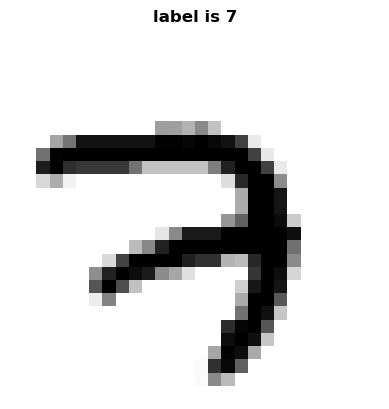

In [142]:

plt.imshow(X_train[0], cmap='binary')
plt.title(f'label is {y_train[0]}')
plt.axis('off')
plt.show()

In [156]:
K = tf.keras.backend


class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate,
                    self.model.optimizer.learning_rate * self.factor)

In [185]:
import numpy as np
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [186]:
model = Sequential([
    Input(shape=X_train.shape[1:]),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

In [187]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________


In [188]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
optim = tf.keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss=loss, optimizer=optim, metrics=['accuracy'])
expon_lr = ExponentialLearningRate(factor=1.005)

In [189]:
history = model.fit(X_train, y_train, epochs=1, batch_size=32,
                    validation_data=(X_valid, y_valid), callbacks=[expon_lr])

1719/1719 [==============================] - 11s 6ms/step - loss: nan - accuracy: 0.5777 - val_loss: nan - val_accuracy: 0.0958


In [190]:
len(expon_lr.losses)  # number of batches processed

1719

In [191]:
expon_lr.rates[:5]  # learning rate logs

[0.001, 0.0010050001, 0.001010025, 0.0010150751, 0.0010201505]

Text(0, 0.5, 'Loss')

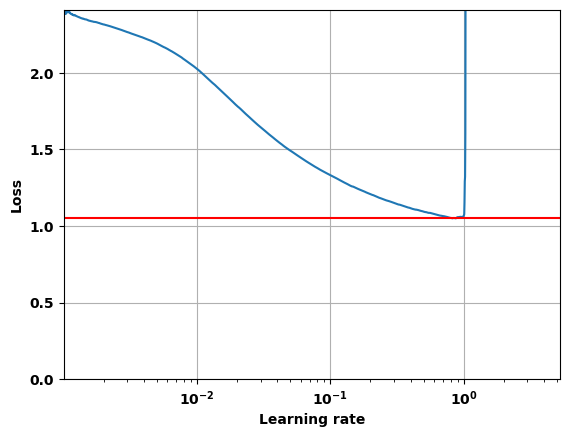

In [192]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates),
           max(expon_lr.rates), color='r')
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

we noticed from the plot that at `learning rate`> 6e-1, the model couldn't converge to the solution.

we will try using half that 3e-1

In [209]:
import numpy as np
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [210]:
model = Sequential([
    Input(shape=X_train.shape[1:]),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

In [211]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________


In [212]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
optim = tf.keras.optimizers.SGD(learning_rate=3e-1)
model.compile(loss=loss, optimizer=optim, metrics=['accuracy'])

In [213]:
run_index = 1  # increment this at every run
run_logdir = Path() / "my_mnist_logs" / "run_{:03d}".format(run_index)
run_logdir

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "my_mnist_model", save_best_only=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

In [214]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=7, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=32,
                    validation_data=(X_valid, y_valid), callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/100
1719/1719 [==============================] - 11s 6ms/step - loss: 0.2345 - accuracy: 0.9264 - val_loss: 0.1150 - val_accuracy: 0.9656
Epoch 2/100
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0970 - accuracy: 0.9699 - val_loss: 0.1024 - val_accuracy: 0.9730
Epoch 3/100
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0662 - accuracy: 0.9796 - val_loss: 0.0707 - val_accuracy: 0.9798
Epoch 4/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0503 - accuracy: 0.9837 - val_loss: 0.0814 - val_accuracy: 0.9774
Epoch 5/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0359 - accuracy: 0.9883 - val_loss: 0.0784 - val_accuracy: 0.9792
Epoch 6/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0289 - accuracy: 0.9906 - val_loss: 0.0899 - val_accuracy: 0.9774
Epoch 7/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0235 - accuracy: 0.9925 - val_loss: 0.0897 - val

In [215]:
best_model = tf.keras.models.load_model(
    "my_mnist_model")  # rollback to best model
best_model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0712 - accuracy: 0.9785


[0.07118447124958038, 0.9785000085830688]

In [217]:
%load_ext tensorboard
%tensorboard --logdir=./my_mnist_logs


In [218]:
!taskkill /IM tensorboard.exe /F

SUCCESS: The process "tensorboard.exe" with PID 15484 has been terminated.
